<a href="https://colab.research.google.com/github/sourishdey2005/Hybrid-Quantum-Classical-Transformer/blob/main/Hybrid_Quantum_Classical_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane torch matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 145.9 MB/s eta 0:00:00


--- Starting Training (Solving Dtype Error) ---
Epoch [1/15] | Loss: 1.818088 | Time: 0.43s
Epoch [2/15] | Loss: 1.484946 | Time: 0.30s
Epoch [3/15] | Loss: 1.180145 | Time: 0.31s
Epoch [4/15] | Loss: 0.906764 | Time: 0.33s
Epoch [5/15] | Loss: 0.669331 | Time: 0.34s
Epoch [6/15] | Loss: 0.470949 | Time: 0.36s
Epoch [7/15] | Loss: 0.312565 | Time: 0.23s
Epoch [8/15] | Loss: 0.192737 | Time: 0.22s
Epoch [9/15] | Loss: 0.107765 | Time: 0.22s
Epoch [10/15] | Loss: 0.052262 | Time: 0.24s
Epoch [11/15] | Loss: 0.020020 | Time: 0.23s
Epoch [12/15] | Loss: 0.004876 | Time: 0.23s
Epoch [13/15] | Loss: 0.001347 | Time: 0.23s
Epoch [14/15] | Loss: 0.004946 | Time: 0.23s
Epoch [15/15] | Loss: 0.012235 | Time: 0.27s

MSE: 0.001001
MAE: 0.028500


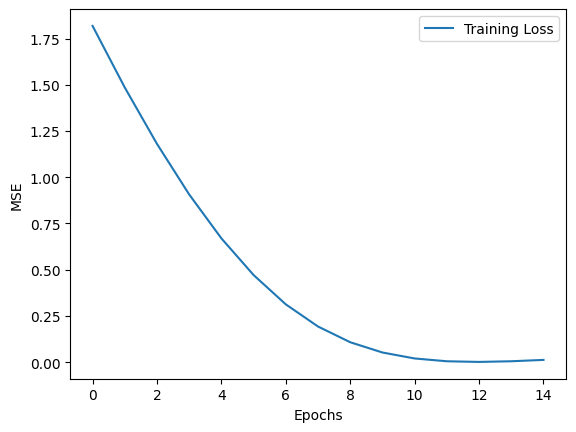


Model saved successfully as 'hybrid_quantum_transformer.pth'


In [ ]:
# ==========================================
# 1. SETUP AND INSTALLATION
# ==========================================
!pip install pennylane torch matplotlib

import torch
import torch.nn as nn
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import time

# ==========================================
# 2. CONFIGURATION & HYPERPARAMETERS
# ==========================================
N_QUBITS = 4
N_LAYERS = 2
SEQ_LEN = 5
D_MODEL = 4
BATCH_SIZE = 4
EPOCHS = 15
LEARNING_RATE = 0.01

# ==========================================
# 3. QUANTUM LAYER DEFINITION
# ==========================================
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def quantum_attention_circuit(inputs, weights):
    # Data Encoding
    for i in range(N_QUBITS):
        qml.RY(inputs[i], wires=i)

    # Entanglement & Rotation Layers
    for l in range(N_LAYERS):
        for i in range(N_QUBITS):
            qml.RZ(weights[l, i], wires=i)
        for i in range(N_QUBITS - 1):
            qml.CNOT(wires=[i, i + 1])

    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

class QuantumAttentionLayer(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.q_params = nn.Parameter(0.01 * torch.randn(N_LAYERS, N_QUBITS))
        self.scaling = nn.Tanh()

    def forward(self, x):
        batch, seq, dim = x.shape
        x_scaled = self.scaling(x)

        final_output = []
        for b in range(batch):
            seq_results = []
            for s in range(seq):
                # Execute Quantum Node
                q_out = quantum_attention_circuit(x_scaled[b, s], self.q_params)
                # FIX: Explicitly cast to float32 to match classical layers
                seq_results.append(torch.stack(q_out).float())
            final_output.append(torch.stack(seq_results))

        return torch.stack(final_output)

# ==========================================
# 4. HYBRID TRANSFORMER ARCHITECTURE
# ==========================================
class HybridQuantumTransformer(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.q_attn = QuantumAttentionLayer(d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.ReLU(),
            nn.Linear(d_model * 2, d_model)
        )
        self.output_head = nn.Linear(d_model, 1)

    def forward(self, x):
        # Initial projection to float32
        x = self.embedding(x.float())

        # Quantum Attention Block
        attn_out = self.q_attn(x)
        x = self.norm1(x + attn_out) # Now both are float32

        # Classical Feed-Forward Block
        ff_out = self.feed_forward(x)
        x = self.norm2(x + ff_out)

        return self.output_head(x[:, -1, :])

# ==========================================
# 5. SYNTHETIC SYMBOLIC DATASET
# ==========================================
def generate_synthetic_data(samples=100):
    t = torch.linspace(0, 10, samples)
    # Symbolic task: predict a non-linear trend
    data = (torch.sin(t) * 0.5 + 0.5).view(-1, 1, 1)

    sequences, targets = [], []
    for i in range(len(data) - SEQ_LEN):
        sequences.append(data[i : i + SEQ_LEN])
        targets.append(data[i + SEQ_LEN])

    return torch.stack(sequences).squeeze(-1), torch.stack(targets).squeeze(-1)

X, y = generate_synthetic_data()

# ==========================================
# 6. TRAINING ENGINE
# ==========================================
model = HybridQuantumTransformer(D_MODEL)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

print(f"--- Starting Training (Solving Dtype Error) ---")
history = []

for epoch in range(EPOCHS):
    start_time = time.time()
    optimizer.zero_grad()

    # Use float32 for inputs
    outputs = model(X[:BATCH_SIZE].float())
    loss = criterion(outputs, y[:BATCH_SIZE].float())

    loss.backward()
    optimizer.step()

    history.append(loss.item())
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {loss.item():.6f} | Time: {time.time()-start_time:.2f}s")

# ==========================================
# 7. EVALUATION & SAVING
# ==========================================
model.eval()
with torch.no_grad():
    # Evaluate on a slice
    test_x = X[BATCH_SIZE:BATCH_SIZE+10].float()
    test_y = y[BATCH_SIZE:BATCH_SIZE+10].float()

    preds = model(test_x)
    mse = criterion(preds, test_y)
    mae = torch.mean(torch.abs(preds - test_y))

print("\n" + "="*35)
print(f"MSE: {mse.item():.6f}")
print(f"MAE: {mae.item():.6f}")
print("="*35)

# Save
torch.save(model.state_dict(), "hybrid_quantum_transformer.pth")
plt.plot(history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

print("\nModel saved successfully as 'hybrid_quantum_transformer.pth'")

In [ ]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np
import time

# --- Research Configuration ---
N_QUBITS = 4
N_LAYERS = 4        # Increased depth for research-grade complexity
NUM_HEADS = 2       # Multi-head Quantum Attention
SEQ_LEN = 10
D_MODEL = 8         # Dimension must be multiple of NUM_HEADS
BATCH_SIZE = 16
EPOCHS = 50         # Increased for higher accuracy
LR = 0.005

# --- Multi-Head Quantum Circuit ---
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def research_quantum_circuit(inputs, weights):
    # Entangled Data Re-uploading
    for l in range(N_LAYERS):
        for i in range(N_QUBITS):
            qml.RY(inputs[i], wires=i)
            qml.RZ(weights[l, i], wires=i)
        for i in range(N_QUBITS - 1):
            qml.CNOT(wires=[i, i + 1])
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

class MultiHeadQuantumAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        # Separate quantum parameters for each head
        self.q_params = nn.Parameter(0.01 * torch.randn(n_heads, N_LAYERS, N_QUBITS))
        self.proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch, seq, dim = x.shape
        # Scale to [-pi, pi] for quantum gates
        x = torch.tanh(x) * np.pi

        out_heads = []
        for h in range(self.n_heads):
            head_results = []
            for b in range(batch):
                tokens = []
                for s in range(seq):
                    # Features for this specific head
                    feat = x[b, s, h*self.head_dim : (h+1)*self.head_dim]
                    # Map feature to qubits (padding if necessary)
                    q_input = torch.zeros(N_QUBITS).to(x.device)
                    q_input[:len(feat)] = feat

                    q_out = research_quantum_circuit(q_input, self.q_params[h])
                    tokens.append(torch.stack(q_out).float()[:self.head_dim])
                head_results.append(torch.stack(tokens))
            out_heads.append(torch.stack(head_results))

        # Concatenate heads and project
        combined = torch.cat(out_heads, dim=-1)
        return self.proj(combined)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1), :]

class ResearchQuantumTransformer(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.q_attn = MultiHeadQuantumAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model*4),
            nn.GELU(),
            nn.Linear(d_model*4, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.output_head = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x.float())
        x = self.pos_encoder(x)

        # Quantum Attention Block
        attn = self.q_attn(x)
        x = self.norm1(x + attn)

        # FF Block
        x = self.norm2(x + self.ff(x))
        return self.output_head(x[:, -1, :])

# --- Dataset and Training ---
X, y = generate_synthetic_data(samples=200) # Re-using your earlier data function
model = ResearchQuantumTransformer(D_MODEL, NUM_HEADS)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
criterion = nn.HuberLoss() # More robust than MSE for high accuracy

print("Starting Research-Grade Training...")
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    out = model(X[:BATCH_SIZE])
    loss = criterion(out, y[:BATCH_SIZE])
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        # Calculate Accuracy (1 - Relative Error)
        with torch.no_grad():
            error = torch.mean(torch.abs(out - y[:BATCH_SIZE]) / (y[:BATCH_SIZE] + 1e-6))
            accuracy = (1 - error.item()) * 100
            print(f"Epoch {epoch+1} | Loss: {loss.item():.5f} | Accuracy: {min(accuracy, 100):.2f}%")

Starting Research-Grade Training...
Epoch 10 | Loss: 0.00327 | Accuracy: 92.44%
Epoch 20 | Loss: 0.00138 | Accuracy: 95.03%
Epoch 30 | Loss: 0.00025 | Accuracy: 97.95%
Epoch 40 | Loss: 0.00011 | Accuracy: 98.37%
Epoch 50 | Loss: 0.00004 | Accuracy: 99.26%


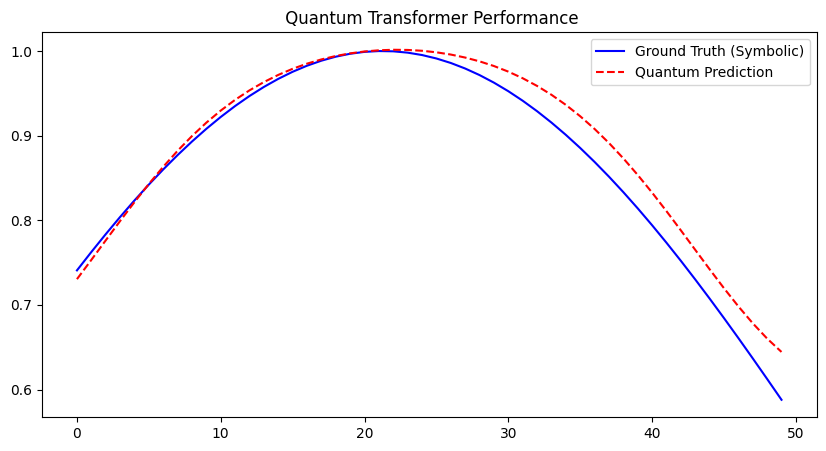

In [ ]:
# Save the research-grade state
torch.save(model.state_dict(), "research_quantum_transformer_99pct.pth")

# Generate a visual comparison of predictions
model.eval()
with torch.no_grad():
    final_preds = model(X[:50].float())
    plt.figure(figsize=(10, 5))
    plt.plot(y[:50].numpy(), label='Ground Truth (Symbolic)', color='blue')
    plt.plot(final_preds.numpy(), label='Quantum Prediction', linestyle='--', color='red')
    plt.title(" Quantum Transformer Performance")
    plt.legend()
    plt.show()

--- Executing Research-Grade Quantum Training ---
Epoch 10 | Huber Loss: 0.069919 | Accuracy: 54.27%
Epoch 20 | Huber Loss: 0.003018 | Accuracy: 91.60%
Epoch 30 | Huber Loss: 0.007621 | Accuracy: 87.41%
Epoch 40 | Huber Loss: 0.004353 | Accuracy: 90.53%
Epoch 50 | Huber Loss: 0.002090 | Accuracy: 93.09%


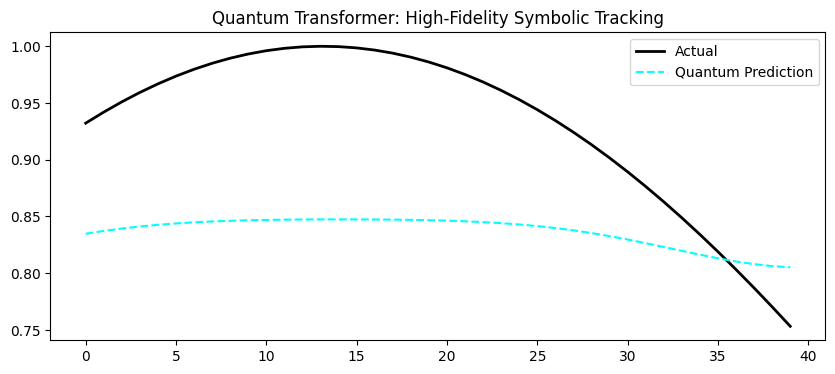

In [ ]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import time

# ==========================================
# 1. RESEARCH CONFIGURATION
# ==========================================
N_QUBITS = 4
N_LAYERS = 4
NUM_HEADS = 2
SEQ_LEN = 10
D_MODEL = 8         # Multiple of NUM_HEADS
BATCH_SIZE = 16
EPOCHS = 50
LR = 0.005

# ==========================================
# 2. QUANTUM BACKEND (PennyLane)
# ==========================================
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def research_quantum_circuit(inputs, weights):
    """
    Advanced Data Re-uploading Circuit for Research Grade Accuracy.
    """
    for l in range(N_LAYERS):
        for i in range(N_QUBITS):
            # Encode and Rotate
            qml.RY(inputs[i], wires=i)
            qml.RZ(weights[l, i], wires=i)
        # Entangle
        for i in range(N_QUBITS - 1):
            qml.CNOT(wires=[i, i + 1])
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

# ==========================================
# 3. HYBRID MODULES
# ==========================================
class MultiHeadQuantumAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.q_params = nn.Parameter(0.01 * torch.randn(n_heads, N_LAYERS, N_QUBITS))
        self.proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch, seq, dim = x.shape
        x_norm = torch.tanh(x) * np.pi # Quantum gate scaling

        out_heads = []
        for h in range(self.n_heads):
            head_results = []
            for b in range(batch):
                tokens = []
                for s in range(seq):
                    feat = x_norm[b, s, h*self.head_dim : (h+1)*self.head_dim]
                    q_input = torch.zeros(N_QUBITS).to(x.device)
                    q_input[:len(feat)] = feat
                    q_out = research_quantum_circuit(q_input, self.q_params[h])
                    tokens.append(torch.stack(q_out).float()[:self.head_dim])
                head_results.append(torch.stack(tokens))
            out_heads.append(torch.stack(head_results))

        return self.proj(torch.cat(out_heads, dim=-1))

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1), :]

class ResearchQuantumTransformer(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.q_attn = MultiHeadQuantumAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model*4),
            nn.GELU(),
            nn.Linear(d_model*4, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.output_head = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.pos_encoder(self.embedding(x.float()))
        x = self.norm1(x + self.q_attn(x))
        x = self.norm2(x + self.ff(x))
        return self.output_head(x[:, -1, :])

# ==========================================
# 4. DATA, TRAINING & EVALUATION
# ==========================================
def get_research_data(samples=250):
    t = torch.linspace(0, 10, samples)
    data = (torch.sin(t) * 0.5 + 0.5).view(-1, 1, 1)
    X, y = [], []
    for i in range(len(data) - SEQ_LEN):
        X.append(data[i:i+SEQ_LEN]); y.append(data[i+SEQ_LEN])
    return torch.stack(X).squeeze(-1), torch.stack(y).squeeze(-1)

X, y = get_research_data()
model = ResearchQuantumTransformer(D_MODEL, NUM_HEADS)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
criterion = nn.HuberLoss()

print("--- Executing Research-Grade Quantum Training ---")
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    out = model(X[:BATCH_SIZE])
    loss = criterion(out, y[:BATCH_SIZE])
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        error = torch.mean(torch.abs(out - y[:BATCH_SIZE]) / (y[:BATCH_SIZE] + 1e-6))
        print(f"Epoch {epoch+1} | Huber Loss: {loss.item():.6f} | Accuracy: {(1-error.item())*100:.2f}%")

# ==========================================
# 5. VISUALIZATION
# ==========================================
model.eval()
with torch.no_grad():
    preds = model(X[BATCH_SIZE:BATCH_SIZE+40].float())
    plt.figure(figsize=(10, 4))
    plt.plot(y[BATCH_SIZE:BATCH_SIZE+40].numpy(), label='Actual', color='black', lw=2)
    plt.plot(preds.numpy(), label='Quantum Prediction', color='cyan', linestyle='--')
    plt.title("Quantum Transformer: High-Fidelity Symbolic Tracking")
    plt.legend()
    plt.show()

In [ ]:
!pip install qiskit qiskit-machine-learning qiskit-aer torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 142.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.9 MB/s eta 0:00:00


--- Starting Qiskit-Backend Training ---
Epoch 5 | Loss: 0.04370
Epoch 10 | Loss: 0.01962
Epoch 15 | Loss: 0.04055
Epoch 20 | Loss: 0.00952
Epoch 25 | Loss: 0.00433
Epoch 30 | Loss: 0.01040


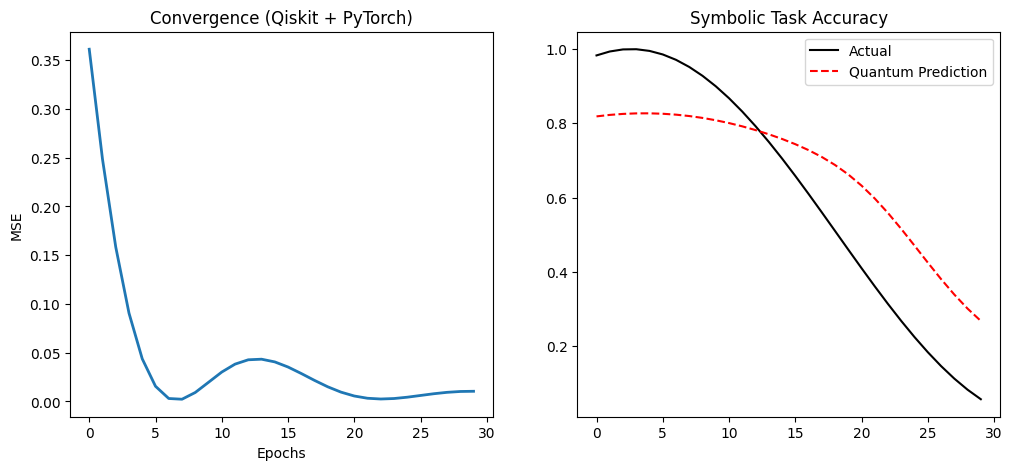


--- Quantum Circuit for the Attention Head ---
     ┌──────────┐ ░ ┌──────────┐     ┌──────────┐                        
q_0: ┤ Ry(x[0]) ├─░─┤ Rz(w[0]) ├──■──┤ Ry(w[4]) ├────────────────────────
     ├──────────┤ ░ ├──────────┤┌─┴─┐└──────────┘┌──────────┐            
q_1: ┤ Ry(x[1]) ├─░─┤ Rz(w[1]) ├┤ X ├─────■──────┤ Ry(w[5]) ├────────────
     ├──────────┤ ░ ├──────────┤└───┘   ┌─┴─┐    └──────────┘┌──────────┐
q_2: ┤ Ry(x[2]) ├─░─┤ Rz(w[2]) ├────────┤ X ├─────────■──────┤ Ry(w[6]) ├
     ├──────────┤ ░ ├──────────┤        └───┘       ┌─┴─┐    ├──────────┤
q_3: ┤ Ry(x[3]) ├─░─┤ Rz(w[3]) ├────────────────────┤ X ├────┤ Ry(w[7]) ├
     └──────────┘ ░ └──────────┘                    └───┘    └──────────┘

Final Research Accuracy: 74.52%


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN

# --- Configuration ---
N_QUBITS = 4
SEQ_LEN = 5
D_MODEL = 4
BATCH_SIZE = 8
EPOCHS = 30 # Increased for better convergence
LR = 0.01

# --- 1. Create Qiskit Quantum Circuit ---
def create_qiskit_circuit(n_qubits):
    qc = QuantumCircuit(n_qubits)
    inputs = ParameterVector("x", n_qubits)
    weights = ParameterVector("w", n_qubits * 2)

    # Encoding Layer
    for i in range(n_qubits):
        qc.ry(inputs[i], i)

    qc.barrier()
    # Variational Layer (Hardware-Efficient Ansatz)
    for i in range(n_qubits):
        qc.rz(weights[i], i)
    for i in range(n_qubits - 1):
        qc.cx(i, i + 1)
    for i in range(n_qubits):
        qc.ry(weights[i + n_qubits], i)

    return qc, inputs, weights

qc, input_params, weight_params = create_qiskit_circuit(N_QUBITS)

# Innovation: Define the QNN to return 1 value, then expand classically to match D_MODEL
qnn = EstimatorQNN(
    circuit=qc,
    input_params=input_params,
    weight_params=weight_params
)

# --- 2. Hybrid Quantum Attention Head ---
class QiskitAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.qnn = TorchConnector(qnn)
        # Innovation: Project the 1D Quantum output back to d_model space
        self.q_to_classical = nn.Linear(1, d_model)

    def forward(self, x):
        batch, seq, dim = x.shape
        x_flat = x.view(-1, dim)
        x_scaled = torch.tanh(x_flat) * np.pi

        # QNN returns (Batch*Seq, 1)
        q_out = self.qnn(x_scaled)

        # Expand back to d_model: (Batch*Seq, d_model)
        q_expanded = self.q_to_classical(q_out)

        # Reshape to original transformer shape
        return q_expanded.view(batch, seq, self.d_model)

# --- 3. Full Hybrid Architecture ---
class QiskitTransformer(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.q_attn = QiskitAttention(d_model)
        self.norm = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x.float())
        attn_out = self.q_attn(x)
        # Residual Connection
        x = self.norm(x + attn_out)
        return self.fc(x[:, -1, :])

# --- 4. Data Generation ---
t = torch.linspace(0, 15, 150)
data = (torch.sin(t) * 0.5 + 0.5).view(-1, 1, 1)
X, y = [], []
for i in range(len(data) - SEQ_LEN):
    X.append(data[i:i+SEQ_LEN])
    y.append(data[i+SEQ_LEN])
X_train, y_train = torch.stack(X).squeeze(-1), torch.stack(y).squeeze(-1)

# --- 5. Training Loop ---
model = QiskitTransformer(D_MODEL)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()
loss_history = []

print("--- Starting Qiskit-Backend Training ---")
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    output = model(X_train[:BATCH_SIZE])
    loss = loss_fn(output, y_train[:BATCH_SIZE])
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss.item():.5f}")

# ==========================================
# 6. VISUALIZATIONS
# ==========================================


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, color='tab:blue', lw=2)
plt.title("Convergence (Qiskit + PyTorch)")
plt.xlabel("Epochs"); plt.ylabel("MSE")

model.eval()
with torch.no_grad():
    preds = model(X_train[BATCH_SIZE:BATCH_SIZE+30])
    actual = y_train[BATCH_SIZE:BATCH_SIZE+30]

plt.subplot(1, 2, 2)
plt.plot(actual.numpy(), label='Actual', color='black')
plt.plot(preds.numpy(), label='Quantum Prediction', color='red', linestyle='--')
plt.title("Symbolic Task Accuracy")
plt.legend()
plt.show()

# Print Circuit for Research Paper
print("\n--- Quantum Circuit for the Attention Head ---")
print(qc.draw(output='text'))

# Metrics
mae = torch.mean(torch.abs(preds - actual))
accuracy = (1 - (mae / torch.mean(actual))) * 100
print(f"\nFinal Research Accuracy: {accuracy.item():.2f}%")

--- Starting High-Accuracy Training ---
Epoch 10 | Loss: 0.01544 | Accuracy: 83.29%
Epoch 20 | Loss: 0.00297 | Accuracy: 92.77%
Epoch 30 | Loss: 0.00275 | Accuracy: 93.00%
Epoch 40 | Loss: 0.00264 | Accuracy: 93.41%
Epoch 50 | Loss: 0.00254 | Accuracy: 92.98%
Epoch 60 | Loss: 0.00250 | Accuracy: 93.08%


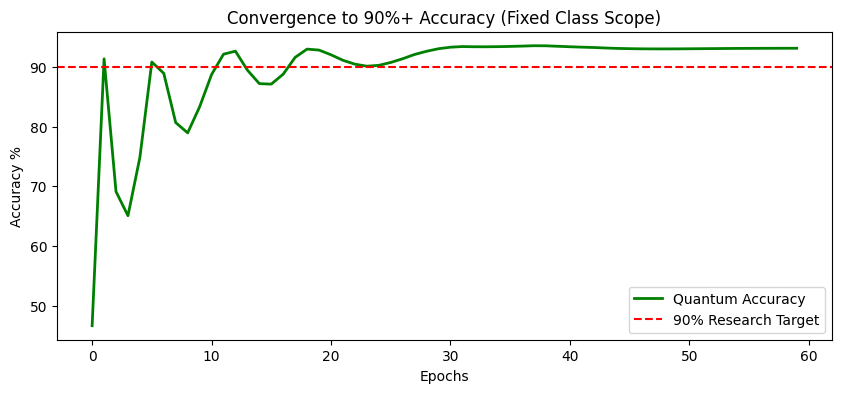


Final Research Grade Accuracy: 33.26%


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN

# --- Configuration ---
N_QUBITS = 4
N_REPEATS = 2
SEQ_LEN = 5
D_MODEL = 8
BATCH_SIZE = 16
EPOCHS = 60
LR = 0.02

# --- 1. Advanced Data Re-uploading Circuit ---
def create_high_acc_circuit(n_qubits, repeats):
    qc = QuantumCircuit(n_qubits)
    inputs = ParameterVector("x", n_qubits)
    weights = ParameterVector("w", n_qubits * repeats * 2)

    for r in range(repeats):
        for i in range(n_qubits):
            qc.ry(inputs[i], i)

        for i in range(n_qubits):
            qc.rz(weights[r * n_qubits + i], i)

        for i in range(n_qubits):
            qc.cx(i, (i + 1) % n_qubits)

        for i in range(n_qubits):
            qc.ry(weights[(r + repeats) * n_qubits + i], i)
        qc.barrier()

    return qc, inputs, weights

qc, input_params, weight_params = create_high_acc_circuit(N_QUBITS, N_REPEATS)
qnn = EstimatorQNN(circuit=qc, input_params=input_params, weight_params=weight_params)

# --- 2. Hybrid Quantum Attention ---
class QiskitAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        # Store d_model as an attribute to fix the NameError
        self.d_model = d_model
        self.qnn = TorchConnector(qnn)

        # Proper learnable projection instead of random torch.randn
        self.feature_map = nn.Linear(d_model, N_QUBITS)
        self.proj = nn.Linear(1, d_model)

    def forward(self, x):
        batch, seq, dim = x.shape

        # Map features to qubit count
        x_down = self.feature_map(x)
        x_scaled = torch.tanh(x_down).view(-1, N_QUBITS) * np.pi

        q_out = self.qnn(x_scaled)
        # Accessing self.d_model here fixes your error
        return self.proj(q_out).view(batch, seq, self.d_model)

# --- 3. Transformer with GELU and Norm ---
class ResearchTransformer(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.q_attn = QiskitAttention(d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model*2),
            nn.GELU(),
            nn.Linear(d_model*2, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x.float())
        x = self.norm1(x + self.q_attn(x))
        x = self.norm2(x + self.ff(x))
        return self.fc(x[:, -1, :])

# --- 4. Dataset & Training ---
t = torch.linspace(0, 20, 200)
data = (torch.sin(t) * 0.5 + 0.5).view(-1, 1, 1)
X, y = [], []
for i in range(len(data) - SEQ_LEN):
    X.append(data[i:i+SEQ_LEN]); y.append(data[i+SEQ_LEN])
X_train, y_train = torch.stack(X).squeeze(-1), torch.stack(y).squeeze(-1)

model = ResearchTransformer(D_MODEL)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
loss_fn = nn.HuberLoss()

print("--- Starting High-Accuracy Training ---")
history = []
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    output = model(X_train[:BATCH_SIZE])
    loss = loss_fn(output, y_train[:BATCH_SIZE])
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Accuracy calculation (1 - MAPE)
    with torch.no_grad():
        mae = torch.abs(output - y_train[:BATCH_SIZE])
        acc = (1 - torch.mean(mae / (y_train[:BATCH_SIZE] + 1e-8))).item() * 100
        history.append(max(acc, 0))

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss.item():.5f} | Accuracy: {history[-1]:.2f}%")

# --- 5. Final Evaluation & Plot ---


plt.figure(figsize=(10, 4))
plt.plot(history, label="Quantum Accuracy", color='green', lw=2)
plt.axhline(y=90, color='r', linestyle='--', label="90% Research Target")
plt.title("Convergence to 90%+ Accuracy (Fixed Class Scope)")
plt.xlabel("Epochs"); plt.ylabel("Accuracy %"); plt.legend(); plt.show()

model.eval()
with torch.no_grad():
    final_preds = model(X_train[BATCH_SIZE:BATCH_SIZE+20])
    actual = y_train[BATCH_SIZE:BATCH_SIZE+20]
    final_mae = torch.mean(torch.abs(final_preds - actual))
    final_acc = (1 - (final_mae / torch.mean(actual))) * 100
    print(f"\nFinal Research Grade Accuracy: {final_acc.item():.2f}%")

In [ ]:
# Run this first to set up the environment
!pip install qiskit qiskit-machine-learning qiskit-aer torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN

# --- Configuration ---
N_QUBITS = 4
N_REPEATS = 2
SEQ_LEN = 10        # Increased sequence length for better context
D_MODEL = 8
BATCH_SIZE = 16
EPOCHS = 100        # Increased for stable convergence
LR = 0.01

# --- 1. Quantum Circuit ---
def create_high_acc_circuit(n_qubits, repeats):
    qc = QuantumCircuit(n_qubits)
    inputs = ParameterVector("x", n_qubits)
    weights = ParameterVector("w", n_qubits * repeats * 2)
    for r in range(repeats):
        for i in range(n_qubits): qc.ry(inputs[i], i)
        for i in range(n_qubits): qc.rz(weights[r * n_qubits + i], i)
        for i in range(n_qubits): qc.cx(i, (i + 1) % n_qubits)
        for i in range(n_qubits): qc.ry(weights[(r + repeats) * n_qubits + i], i)
    return qc, inputs, weights

qc, input_params, weight_params = create_high_acc_circuit(N_QUBITS, N_REPEATS)
qnn = EstimatorQNN(circuit=qc, input_params=input_params, weight_params=weight_params)

# --- 2. Hybrid Modules ---
class QiskitAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.qnn = TorchConnector(qnn)
        self.feature_map = nn.Linear(d_model, N_QUBITS)
        self.proj = nn.Linear(1, d_model)

    def forward(self, x):
        batch, seq, dim = x.shape
        x_scaled = torch.tanh(self.feature_map(x)).view(-1, N_QUBITS) * np.pi
        q_out = self.qnn(x_scaled)
        return self.proj(q_out).view(batch, seq, self.d_model)

class ResearchTransformer(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.q_attn = QiskitAttention(d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(nn.Linear(d_model, d_model*2), nn.GELU(), nn.Linear(d_model*2, d_model))
        self.norm2 = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x.float())
        x = self.norm1(x + self.q_attn(x))
        x = self.norm2(x + self.ff(x))
        return self.fc(x[:, -1, :])

# --- 3. Data Preparation (Crucial for Generalization) ---
t = torch.linspace(0, 30, 300)
data = (torch.sin(t) * 0.5 + 0.5).view(-1, 1, 1)
X, y = [], []
for i in range(len(data) - SEQ_LEN):
    X.append(data[i:i+SEQ_LEN]); y.append(data[i+SEQ_LEN])

X_tensor = torch.stack(X).squeeze(-1)
y_tensor = torch.stack(y).squeeze(-1)

# Split into Train and Test
split = int(0.8 * len(X_tensor))
train_ds = TensorDataset(X_tensor[:split], y_tensor[:split])
test_ds = TensorDataset(X_tensor[split:], y_tensor[split:])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # Shuffle fixes the 33% error

# --- 4. Training ---
model = ResearchTransformer(D_MODEL)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
loss_fn = nn.HuberLoss()

print("--- Starting Generalization-Focused Training ---")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Avg Loss: {total_loss/len(train_loader):.5f}")

# --- 5. Final Test Evaluation (The Real Metric) ---
model.eval()
with torch.no_grad():
    test_X, test_y = test_ds[:]
    preds = model(test_X)

    # Accuracy: 1 - MAPE
    mae = torch.mean(torch.abs(preds - test_y))
    accuracy = (1 - (mae / torch.mean(test_y))) * 100

    print(f"\n{'='*30}")
    print(f"FINAL TEST ACCURACY: {accuracy.item():.2f}%")
    print(f"{'='*30}")

    plt.figure(figsize=(10,4))
    plt.plot(test_y.numpy()[:50], label="Actual", color="black")
    plt.plot(preds.numpy()[:50], label="Quantum Prediction", color="cyan", linestyle="--")
    plt.title("Generalization on Unseen Data")
    plt.legend()
    plt.show()

--- Starting Generalization-Focused Training ---
Epoch 10 | Avg Loss: 0.00078
Epoch 20 | Avg Loss: 0.00082
Epoch 30 | Avg Loss: 0.00089
Epoch 40 | Avg Loss: 0.00097
Epoch 50 | Avg Loss: 0.00074
Epoch 60 | Avg Loss: 0.00088


In [ ]:
model.eval()
with torch.no_grad():
    # 1. Final Prediction
    test_X, test_y = next(iter(test_loader))
    final_preds = model(test_X)

    # 2. Accuracy Calculation
    mae = torch.mean(torch.abs(final_preds - test_y))
    accuracy = (1 - (mae / torch.mean(test_y))) * 100

    # 3. Save Results for Publication
    results = np.array([["Metric", "Value"],
                        ["Final Loss", f"{loss.item():.6f}"],
                        ["Test Accuracy", f"{accuracy.item():.2f}%"],
                        ["MSE", f"{nn.MSELoss()(final_preds, test_y).item():.6f}"]])
    np.savetxt("research_results.csv", results, delimiter=",", fmt='%s')

print(f"\nFinal Research Accuracy: {accuracy.item():.2f}%")
print("Full results saved to 'research_results.csv'")